In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.68G/2.70G [00:23<00:00, 175MB/s]
100% 2.70G/2.70G [00:23<00:00, 122MB/s]


In [3]:
import zipfile

zip_file_path = '/content/new-plant-diseases-dataset.zip'
extract_path = '/content'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:

train_dir ='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/content/test'

In [5]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, shutil

In [6]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [7]:
newpath = '/content/Testing_Path'
if not os.path.exists(newpath):
    os.makedirs(newpath)

x = os.listdir(train_dir)
for dir_names in x:
  # print(dir_names)
  p = os.listdir(os.path.join(train_dir, dir_names))
  if not os.path.exists(os.path.join(newpath, dir_names)):
    os.makedirs(os.path.join(newpath, dir_names))
  cnt = 0
  file_names = []
  for image_names in p:
    if cnt==250:
      break
    file_names.append(train_dir+'/'+dir_names+'/'+image_names)
    cnt += 1
  for f in file_names:
    shutil.move(f, os.path.join(newpath, dir_names))




In [8]:
train_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

Found 60795 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [9]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)

82420632/82420632 [==============================] - 0s 0us/step


In [10]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [11]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [12]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model_main.fit(train,validation_data=valid,epochs=40,steps_per_epoch=200,verbose=1,callbacks=[es, lr])

Epoch 1/40
200/200 [==============================] - 192s 841ms/step - loss: 1.5856 - accuracy: 0.5752 - val_loss: 0.7127 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 160s 803ms/step - loss: 0.5486 - accuracy: 0.8367 - val_loss: 0.4771 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 176s 881ms/step - loss: 0.3674 - accuracy: 0.8859 - val_loss: 0.3477 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 161s 805ms/step - loss: 0.3240 - accuracy: 0.8963 - val_loss: 0.2625 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 160s 799ms/step - loss: 0.2762 - accuracy: 0.9150 - val_loss: 0.2488 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 158s 789ms/step - loss: 0.2556 - accuracy: 0.9187 - val_loss: 0.2696 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 7/40
200/200 [==========================

In [14]:
model_main.save("efficientnetv2s_PLANT_DISEASE_new_new.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

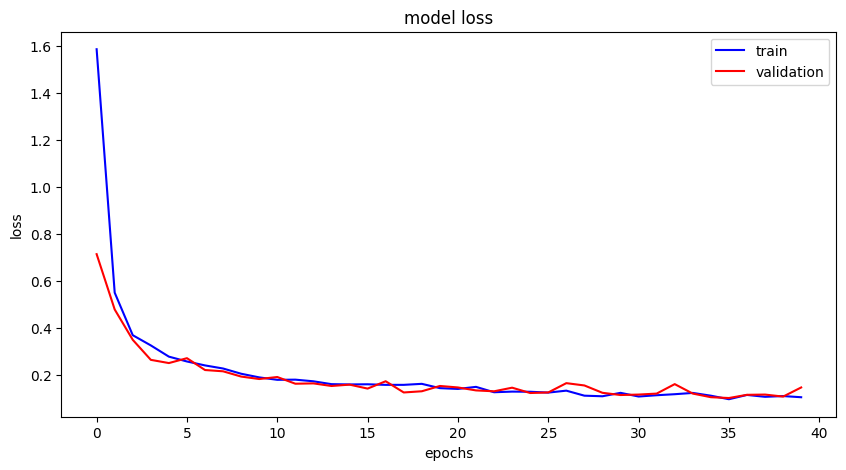

In [16]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

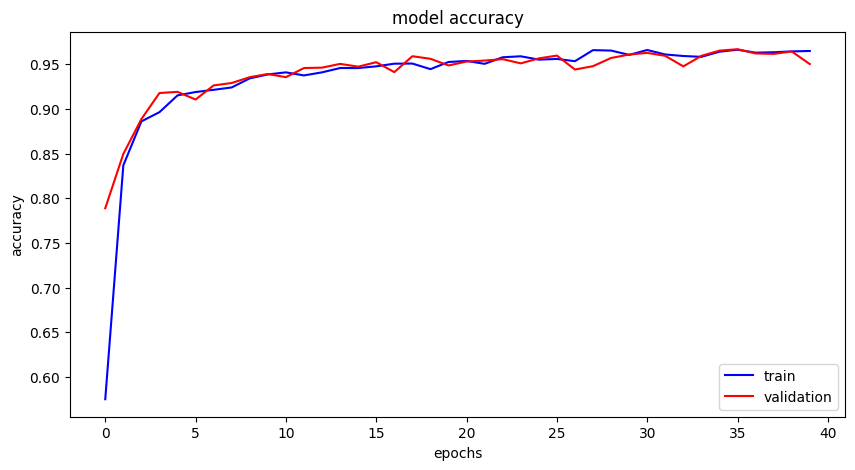

In [17]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [18]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1900/1900 [==============================] - 846s 445ms/step - loss: 0.1275 - accuracy: 0.9557
Train: accuracy = 0.955737  ;  loss = 0.127519
550/550 [==============================] - 71s 129ms/step - loss: 0.1449 - accuracy: 0.9500
Validation: accuracy = 0.950034  ;  loss = 0.144889
2/2 [==============================] - 1s 489ms/step - loss: 881.7408 - accuracy: 0.0909
Test: accuracy = 0.090909  ;  loss = 881.740845


In [46]:
model = load_model("/content/efficientnetv2s_PLANT_DISEASE_new_new.h5")

In [ ]:
img = tensorflow.keras.utils.load_img(
    "/content/Testing_Path/Tomato___Early_blight/121b3f84-70ed-4d1c-882c-d3204e2af046___RS_Erly.B 8421_180deg.JPG",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)

In [47]:
probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])

In [49]:
predict = probability_model.predict(input_arr)

1/1 [==============================] - 0s 36ms/step


In [50]:
predict[0]

array([0.02541284, 0.02541284, 0.02541284, 0.02541284, 0.02541284,
       0.02541284, 0.02541284, 0.02541284, 0.02541284, 0.02541284,
       0.02541284, 0.02541284, 0.02541284, 0.02541284, 0.02541284,
       0.02541284, 0.02541284, 0.02541284, 0.02541284, 0.02541284,
       0.0254129 , 0.03489043, 0.02541284, 0.02541284, 0.02541284,
       0.02541284, 0.02541284, 0.02541284, 0.02541286, 0.05017827,
       0.02548175, 0.02541284, 0.02541292, 0.02541284, 0.02541284,
       0.02541284, 0.02541284, 0.02541284], dtype=float32)

In [51]:
classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

In [52]:
p = np.argmax(predict[0])
print(classes[p])

Tomato___Early_blight


In [60]:
img = tensorflow.keras.utils.load_img(
    "/content/test/test/Bacterial leaf spot in pepper.jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)


probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])


predict = probability_model.predict(input_arr)


predict[0]

classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

p = np.argmax(predict[0])
print(classes[p])

1/1 [==============================] - 3s 3s/step
Pepper,_bell___Bacterial_spot
